In [ ]:
#import statements
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
from tqdm._tqdm_notebook import tqdm_notebook as tqdm
import seaborn as sns
from PIL import Image
import tensorflow as tf
from google.colab import drive
from sklearn.metrics import confusion_matrix
import keras
from keras.utils.np_utils import to_categorical 
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, Activation, GlobalAveragePooling2D, ZeroPadding2D
from keras.applications import vgg16
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from tensorflow.keras.models import Model

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  import sys


In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! unzip '/content/drive/MyDrive/HAM10000_metadata_gc.zip'

Archive:  /content/drive/MyDrive/HAM10000_metadata_gc.zip
  inflating: HAM10000_metadata       


In [ ]:
! unzip '/content/drive/MyDrive/HAM10000_images_part_1_gc'

In [ ]:
! unzip '/content/drive/MyDrive/HAM10000_images_part_2_gc'

In [ ]:
md = pd.read_csv("/content/HAM10000_metadata")
md

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern
...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,vidir_modern
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,vidir_modern
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,vidir_modern
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,vidir_modern


In [ ]:
#vgg16 model accepts images of 224X224X3
im_size = 224

In [ ]:
#set aside a portion of full dataset for testing
dxs = md["dx"].unique()

ldxs = {}

for dx, group in md.groupby("dx"):
    ldxs[dx] = []
    images = list(group["image_id"])
    np.random.shuffle(images)
    for i in range(75):
        ldxs[dx].append(images[i])

In [ ]:
ts = pd.DataFrame.from_dict(ldxs, orient='index')
ts = ts.T
ts

,akiec,bcc,bkl,df,mel,nv,vasc
0,ISIC_0026765,ISIC_0025711,ISIC_0030583,ISIC_0033554,ISIC_0034173,ISIC_0028012,ISIC_0025680
1,ISIC_0033151,ISIC_0031056,ISIC_0027463,ISIC_0025373,ISIC_0032081,ISIC_0027031,ISIC_0032614
2,ISIC_0029315,ISIC_0032696,ISIC_0030698,ISIC_0033695,ISIC_0025751,ISIC_0032551,ISIC_0027903
3,ISIC_0025712,ISIC_0028719,ISIC_0027680,ISIC_0031827,ISIC_0033324,ISIC_0028535,ISIC_0030275
4,ISIC_0032203,ISIC_0032316,ISIC_0027533,ISIC_0026313,ISIC_0033612,ISIC_0026027,ISIC_0026490
...,...,...,...,...,...,...,...
70,ISIC_0026327,ISIC_0028747,ISIC_0032359,ISIC_0030442,ISIC_0031377,ISIC_0029507,ISIC_0027790
71,ISIC_0026152,ISIC_0034306,ISIC_0027027,ISIC_0031002,ISIC_0027171,ISIC_0027430,ISIC_0024662
72,ISIC_0026984,ISIC_0033001,ISIC_0028876,ISIC_0025980,ISIC_0026089,ISIC_0033556,ISIC_0032240
73,ISIC_0030191,ISIC_0024472,ISIC_0029425,ISIC_0024845,ISIC_0024367,ISIC_0033737,ISIC_0032538


In [ ]:
t_akiec_imid = ts.akiec.values.tolist()
t_akiec_dx = ['akiec'] * 75
ts_aikec = pd.DataFrame(list(zip(t_akiec_imid, t_akiec_dx)), columns=['image_id', 'dx'])

t_bcc_imid = ts.bcc.values.tolist()
t_bcc_dx = ['bcc'] * 75
ts_bcc = pd.DataFrame(list(zip(t_bcc_imid, t_bcc_dx)), columns=['image_id', 'dx'])

t_bkl_imid = ts.bkl.values.tolist()
t_bkl_dx = ['bkl'] * 75
ts_bkl = pd.DataFrame(list(zip(t_bkl_imid, t_bkl_dx)), columns=['image_id', 'dx'])

t_df_imid = ts.df.values.tolist()
t_df_dx = ['df'] * 75
ts_df = pd.DataFrame(list(zip(t_df_imid, t_df_dx)), columns=['image_id', 'dx'])

t_mel_imid = ts.mel.values.tolist()
t_mel_dx = ['mel'] * 75
ts_mel = pd.DataFrame(list(zip(t_mel_imid, t_mel_dx)), columns=['image_id', 'dx'])

t_nv_imid = ts.nv.values.tolist()
t_nv_dx = ['nv'] * 75
ts_nv = pd.DataFrame(list(zip(t_nv_imid, t_nv_dx)), columns=['image_id', 'dx'])

t_vasc_imid = ts.vasc.values.tolist()
t_vasc_dx = ['vasc'] * 75
ts_vasc = pd.DataFrame(list(zip(t_vasc_imid, t_vasc_dx)), columns=['image_id', 'dx'])

ts_balanced = pd.concat([ts_aikec, ts_bcc, ts_bkl, ts_df, ts_mel, ts_nv, ts_vasc])
ts_balanced

,image_id,dx
0,ISIC_0026765,akiec
1,ISIC_0033151,akiec
2,ISIC_0029315,akiec
3,ISIC_0025712,akiec
4,ISIC_0032203,akiec
...,...,...
70,ISIC_0027790,vasc
71,ISIC_0024662,vasc
72,ISIC_0032240,vasc
73,ISIC_0032538,vasc


In [ ]:
cond = md['image_id'].isin(ts_balanced['image_id'])
trainset = md.drop(md[cond].index)

trainset

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern
...,...,...,...,...,...,...,...,...
10005,HAM_0005579,ISIC_0028393,akiec,histo,80.0,male,face,rosendahl
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,vidir_modern
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,vidir_modern
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,vidir_modern


In [ ]:
#label encoding: going from text to numerical
lab_enc = LabelEncoder()
lab_enc.fit(trainset['dx'])
LabelEncoder()
print(list(lab_enc.classes_))

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


In [ ]:
lab_enc = LabelEncoder()
lab_enc.fit(ts_balanced['dx'])
LabelEncoder()
print(list(lab_enc.classes_))

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


In [ ]:
#label column in md - diagnosis and numerical label in one dataset
trainset['label'] = lab_enc.transform(trainset["dx"]) 
ts_balanced['label'] = lab_enc.transform(ts_balanced["dx"]) 
trainset

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,label
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,2
...,...,...,...,...,...,...,...,...,...
10005,HAM_0005579,ISIC_0028393,akiec,histo,80.0,male,face,rosendahl,0
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,vidir_modern,0
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,vidir_modern,0
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,vidir_modern,0


In [ ]:
ts_balanced

,image_id,dx,label
0,ISIC_0026765,akiec,0
1,ISIC_0033151,akiec,0
2,ISIC_0029315,akiec,0
3,ISIC_0025712,akiec,0
4,ISIC_0032203,akiec,0
...,...,...,...
70,ISIC_0027790,vasc,6
71,ISIC_0024662,vasc,6
72,ISIC_0032240,vasc,6
73,ISIC_0032538,vasc,6


In [ ]:
#get all file paths and make a new column
fldr1 = '/content/HAM10000_images_part_1'
fldr2 = '/content/HAM10000_images_part_2'

im_paths = []

for i in trainset['image_id']:
  fid = i

  fn = '/' + fid + '.jpg'

  if os.path.isfile(fldr1 + fn) == True:
    im_paths.append(fldr1+fn)
  else:
    im_paths.append(fldr2+fn)

In [ ]:
trainset['image_paths'] = im_paths

trainset

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,label,image_paths
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern,2,/content/HAM10000_images_part_1/ISIC_0027419.jpg
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern,2,/content/HAM10000_images_part_1/ISIC_0025030.jpg
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,2,/content/HAM10000_images_part_1/ISIC_0026769.jpg
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,2,/content/HAM10000_images_part_1/ISIC_0025661.jpg
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,2,/content/HAM10000_images_part_2/ISIC_0031633.jpg
...,...,...,...,...,...,...,...,...,...,...
10005,HAM_0005579,ISIC_0028393,akiec,histo,80.0,male,face,rosendahl,0,/content/HAM10000_images_part_1/ISIC_0028393.jpg
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,vidir_modern,0,/content/HAM10000_images_part_2/ISIC_0033084.jpg
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,vidir_modern,0,/content/HAM10000_images_part_2/ISIC_0033550.jpg
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,vidir_modern,0,/content/HAM10000_images_part_2/ISIC_0033536.jpg


In [ ]:
fldr1 = '/content/HAM10000_images_part_1'
fldr2 = '/content/HAM10000_images_part_2'

im_paths2 = []

for i in ts_balanced['image_id']:
  fid = i

  fn = '/' + fid + '.jpg'

  if os.path.isfile(fldr1 + fn) == True:
    im_paths2.append(fldr1+fn)
  else:
    im_paths2.append(fldr2+fn)

In [ ]:
ts_balanced['image_paths'] = im_paths2
ts_balanced

,image_id,dx,label,image_paths
0,ISIC_0026765,akiec,0,/content/HAM10000_images_part_1/ISIC_0026765.jpg
1,ISIC_0033151,akiec,0,/content/HAM10000_images_part_2/ISIC_0033151.jpg
2,ISIC_0029315,akiec,0,/content/HAM10000_images_part_2/ISIC_0029315.jpg
3,ISIC_0025712,akiec,0,/content/HAM10000_images_part_1/ISIC_0025712.jpg
4,ISIC_0032203,akiec,0,/content/HAM10000_images_part_2/ISIC_0032203.jpg
...,...,...,...,...
70,ISIC_0027790,vasc,6,/content/HAM10000_images_part_1/ISIC_0027790.jpg
71,ISIC_0024662,vasc,6,/content/HAM10000_images_part_1/ISIC_0024662.jpg
72,ISIC_0032240,vasc,6,/content/HAM10000_images_part_2/ISIC_0032240.jpg
73,ISIC_0032538,vasc,6,/content/HAM10000_images_part_2/ISIC_0032538.jpg


In [ ]:
#seperate data into diagnoses
dx_0 = trainset[trainset['label'] == 0]
dx_1 = trainset[trainset['label'] == 1]
dx_2 = trainset[trainset['label'] == 2]
dx_3 = trainset[trainset['label'] == 3]
dx_4 = trainset[trainset['label'] == 4]
dx_5 = trainset[trainset['label'] == 5]
dx_6 = trainset[trainset['label'] == 6]

In [ ]:
from pandas.core.common import random_state
#subset and random resample of data by diagnosis
n = 1000
dx_0_balanced = resample(dx_0, replace=True, n_samples=n, random_state=42) 
dx_1_balanced = resample(dx_1, replace=True, n_samples=n, random_state=42) 
dx_2_balanced = resample(dx_2, replace=True, n_samples=n, random_state=42)
dx_3_balanced = resample(dx_3, replace=True, n_samples=n, random_state=42)
dx_4_balanced = resample(dx_4, replace=True, n_samples=n, random_state=42)
dx_5_balanced = resample(dx_5, replace=True, n_samples=n, random_state=42)
dx_6_balanced = resample(dx_6, replace=True, n_samples=n, random_state=42)

In [ ]:
trainset_balanced = pd.concat([dx_0_balanced, dx_1_balanced, dx_2_balanced, dx_3_balanced, dx_4_balanced, dx_5_balanced, dx_6_balanced])

trainset_balanced

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,label,image_paths
9812,HAM_0005264,ISIC_0029371,akiec,histo,45.0,male,back,rosendahl,0,/content/HAM10000_images_part_2/ISIC_0029371.jpg
9914,HAM_0005551,ISIC_0029900,akiec,histo,60.0,male,face,rosendahl,0,/content/HAM10000_images_part_2/ISIC_0029900.jpg
9797,HAM_0006481,ISIC_0027753,akiec,histo,70.0,male,upper extremity,rosendahl,0,/content/HAM10000_images_part_1/ISIC_0027753.jpg
9704,HAM_0005027,ISIC_0032329,akiec,histo,85.0,female,back,rosendahl,0,/content/HAM10000_images_part_2/ISIC_0032329.jpg
9818,HAM_0005924,ISIC_0030953,akiec,histo,80.0,female,upper extremity,rosendahl,0,/content/HAM10000_images_part_2/ISIC_0030953.jpg
...,...,...,...,...,...,...,...,...,...,...
2323,HAM_0001920,ISIC_0031901,vasc,histo,55.0,male,back,vidir_modern,6,/content/HAM10000_images_part_2/ISIC_0031901.jpg
2369,HAM_0006946,ISIC_0032866,vasc,histo,55.0,female,back,vidir_modern,6,/content/HAM10000_images_part_2/ISIC_0032866.jpg
2448,HAM_0006447,ISIC_0031276,vasc,consensus,75.0,male,abdomen,vidir_molemax,6,/content/HAM10000_images_part_2/ISIC_0031276.jpg
2378,HAM_0007097,ISIC_0034214,vasc,histo,60.0,male,trunk,vidir_modern,6,/content/HAM10000_images_part_2/ISIC_0034214.jpg


In [ ]:
#turn images to array and add as a new column 
trainset_balanced['image'] = trainset_balanced['image_paths'].map(lambda x: np.asarray(Image.open(x).resize((im_size,im_size))))

In [ ]:
ts_balanced['image'] = ts_balanced['image_paths'].map(lambda x: np.asarray(Image.open(x).resize((im_size,im_size))))

ts_balanced

,image_id,dx,label,image_paths,image
0,ISIC_0026765,akiec,0,/content/HAM10000_images_part_1/ISIC_0026765.jpg,"[[[209, 172, 163], [212, 177, 166], [213, 178,..."
1,ISIC_0033151,akiec,0,/content/HAM10000_images_part_2/ISIC_0033151.jpg,"[[[137, 97, 102], [138, 96, 105], [138, 96, 10..."
2,ISIC_0029315,akiec,0,/content/HAM10000_images_part_2/ISIC_0029315.jpg,"[[[177, 149, 148], [176, 151, 150], [175, 152,..."
3,ISIC_0025712,akiec,0,/content/HAM10000_images_part_1/ISIC_0025712.jpg,"[[[185, 134, 143], [177, 123, 130], [177, 121,..."
4,ISIC_0032203,akiec,0,/content/HAM10000_images_part_2/ISIC_0032203.jpg,"[[[183, 163, 163], [181, 160, 159], [174, 154,..."
...,...,...,...,...,...
70,ISIC_0027790,vasc,6,/content/HAM10000_images_part_1/ISIC_0027790.jpg,"[[[172, 123, 135], [172, 124, 133], [172, 124,..."
71,ISIC_0024662,vasc,6,/content/HAM10000_images_part_1/ISIC_0024662.jpg,"[[[236, 136, 155], [238, 132, 156], [234, 127,..."
72,ISIC_0032240,vasc,6,/content/HAM10000_images_part_2/ISIC_0032240.jpg,"[[[203, 171, 186], [202, 171, 186], [202, 174,..."
73,ISIC_0032538,vasc,6,/content/HAM10000_images_part_2/ISIC_0032538.jpg,"[[[28, 22, 23], [28, 24, 24], [35, 25, 27], [4..."


In [ ]:
X_trainset = np.asarray(trainset_balanced['image'].tolist())
X_trainset = X_trainset/255. 
Y_trainset = trainset_balanced['label']
Y_dx_trainset = to_categorical(Y_trainset, num_classes=7)

In [ ]:
X_ts = np.asarray(ts_balanced['image'].tolist())
X_ts = X_ts/255. 
Y_ts = ts_balanced['label']
Y_dx_ts = to_categorical(Y_ts, num_classes=7)

In [ ]:
#train/validation split - 70/30 split

x_train, x_val, y_train, y_val = train_test_split(X_trainset, Y_dx_trainset, test_size=0.30, random_state=29)

In [ ]:
#GPU
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
#model

img_rows, img_cols = 224, 224 

vgg_mod = vgg16.VGG16(weights = 'imagenet', 
                 include_top = False, 
                 input_shape = (img_rows, img_cols, 3))

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
#freeze last 4 layers
for layer in vgg_mod.layers:
    layer.trainable = False

In [ ]:
for (i,layer) in enumerate(vgg_mod.layers):
    print(str(i) + " "+ layer.__class__.__name__, layer.trainable)

0 InputLayer False
1 Conv2D False
2 Conv2D False
3 MaxPooling2D False
4 Conv2D False
5 Conv2D False
6 MaxPooling2D False
7 Conv2D False
8 Conv2D False
9 Conv2D False
10 MaxPooling2D False
11 Conv2D False
12 Conv2D False
13 Conv2D False
14 MaxPooling2D False
15 Conv2D False
16 Conv2D False
17 Conv2D False
18 MaxPooling2D False


In [ ]:
#top layers replaced by our own - 7 classes. Other layers used as is and as trained on Imagenet

def lw(bottom_model, num_classes):
    """creates the top or head of the model that will be 
    placed ontop of the bottom layers"""

    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(512,activation='relu')(top_model)
    top_model = Dense(num_classes,activation='softmax')(top_model)
    return top_model 

In [ ]:
num_classes = 7

FC_Head = lw(vgg_mod, num_classes)
model = Model(inputs = vgg_mod.input, outputs = FC_Head)
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
model.compile(optimizer='adam', loss = 'categorical_crossentropy',metrics = ['accuracy'])

In [ ]:
#training

batch_size = 16 
epochs = 75

In [ ]:
mod_fit = model.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size = batch_size,
    validation_data=(x_val, y_val),
    verbose=2)

Epoch 1/75
307/307 - 18s - loss: 1.6578 - accuracy: 0.3414 - val_loss: 1.4641 - val_accuracy: 0.4319 - 18s/epoch - 57ms/step
Epoch 2/75
307/307 - 7s - loss: 1.3945 - accuracy: 0.4612 - val_loss: 1.3810 - val_accuracy: 0.4800 - 7s/epoch - 21ms/step
Epoch 3/75
307/307 - 7s - loss: 1.2824 - accuracy: 0.5082 - val_loss: 1.2050 - val_accuracy: 0.5605 - 7s/epoch - 21ms/step
Epoch 4/75
307/307 - 7s - loss: 1.1685 - accuracy: 0.5516 - val_loss: 1.1639 - val_accuracy: 0.5657 - 7s/epoch - 21ms/step
Epoch 5/75
307/307 - 7s - loss: 1.0677 - accuracy: 0.5967 - val_loss: 1.1686 - val_accuracy: 0.5524 - 7s/epoch - 21ms/step
Epoch 6/75
307/307 - 7s - loss: 1.0164 - accuracy: 0.6078 - val_loss: 1.0936 - val_accuracy: 0.5657 - 7s/epoch - 22ms/step
Epoch 7/75
307/307 - 7s - loss: 0.9731 - accuracy: 0.6208 - val_loss: 1.0181 - val_accuracy: 0.6038 - 7s/epoch - 22ms/step
Epoch 8/75
307/307 - 7s - loss: 0.9260 - accuracy: 0.6433 - val_loss: 0.9962 - val_accuracy: 0.5990 - 7s/epoch - 22ms/step
Epoch 9/75
307

In [ ]:
mod_acc_val = model.evaluate(x_val, y_val)
print('Validation accuracy:', mod_acc_val[1])

66/66 [==============================] - 2s 26ms/step - loss: 0.9936 - accuracy: 0.8376
Validation accuracy: 0.8376190662384033


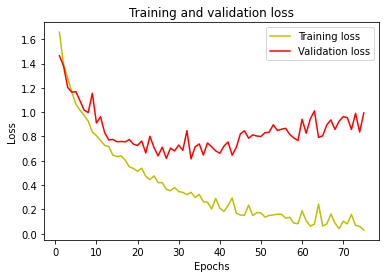

In [ ]:
loss = mod_fit.history['loss']
val_loss = mod_fit.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

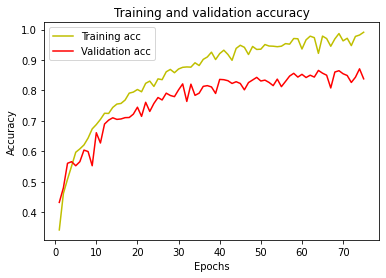

In [ ]:
acc = mod_fit.history['accuracy']
val_acc = mod_fit.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
y_pred = model.predict(X_ts)

17/17 [==============================] - 1s 45ms/step


In [ ]:
#one hot encoding --> probs from softmax to 1 and 0
y_pred_classes = np.argmax(y_pred, axis = 1) 

In [ ]:
y_true = np.argmax(Y_dx_ts, axis = 1) 

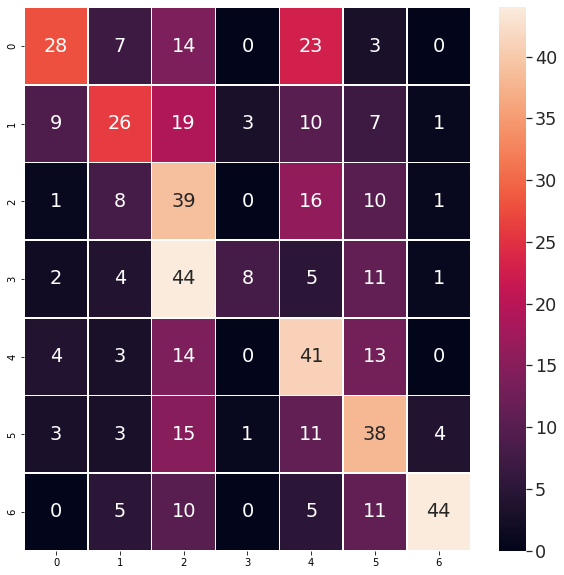

In [ ]:
cm = confusion_matrix(y_true, y_pred_classes)
fig, ax = plt.subplots(figsize=(10,10))
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)

In [ ]:
incorr_fraction = 1 - np.diag(cm) / np.sum(cm, axis=1)

incorr_fraction = incorr_fraction.tolist()

incorr_fraction = [round(item, 2) for item in incorr_fraction]

incorr_fraction

[0.63, 0.65, 0.48, 0.89, 0.45, 0.49, 0.41]

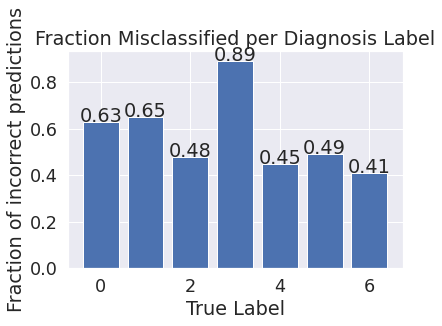

In [ ]:
#percent misclassified per dx
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center')
  
if __name__ == '__main__':
  plt.bar(np.arange(7), incorr_fraction)
  addlabels(np.arange(7), incorr_fraction)
  plt.title("Fraction Misclassified per Diagnosis Label")
  plt.xlabel('True Label')
  plt.ylabel('Fraction of incorrect predictions')

In [ ]:
mod_acc_test = model.evaluate(X_ts, Y_dx_ts)
print('Test accuracy:', mod_acc_test[1])

17/17 [==============================] - 0s 26ms/step - loss: 5.3368 - accuracy: 0.4267
Test accuracy: 0.4266666769981384


In [ ]:
#reference
#https://www.youtube.com/watch?v=Fxy6WTnUIww
#https://keras.io/api/layers/core_layers/dense/
#https://keras.io/api/models/model/
#https://www.educba.com/keras-fit/
#https://www.geeksforgeeks.org/adding-value-labels-on-a-matplotlib-bar-chart/
#https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.transpose.html
#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.from_dict.html
#https://www.geeksforgeeks.org/drop-rows-from-the-dataframe-based-on-certain-condition-applied-on-a-column/
#https://sparkbyexamples.com/pandas/conver-pandas-column-to-list/
#https://datascience.stackexchange.com/questions/37227/how-to-remove-rows-from-a-dataframe-that-are-identical-to-another-dataframe

In [ ]:
0 - 0.36
1 - 0.35
2 - 0.52
3 - 0.11
4 - 0.55
5 - 0.51
6 - 0.59